# Pytorch Multi-output GPR

The purpose of this notebook is to predict the soil type and soil thickness of Layer 1 as a Multi-Output GP model using a ModelList. Unlike a Multi-Task model, Multi-Output models do not represent correlations between outcomes, but treat outcomes independently. 

#### Import libraries

In [1]:
!pip install torch --quiet
!pip install gpytorch --quiet

In [2]:
import os
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import torch
import gpytorch
from gpytorch.models import ApproximateGP, ExactGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import SoftmaxLikelihood, GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

____________________

#### Load training data points

In [3]:
# Load the training data CSV file compiled in `1-data_access.ipynb`
input_file = '../data/2.1-seattle_layer1_trainingdata.csv'
training_data = pd.read_csv(input_file)

# Create a GeoDataFrame from the DataFrame
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.points_from_xy(training_data.LONGITUDE, training_data.LATITUDE))
    
# Set the CRS to WGS84 (latitude and longitude)
training_data.set_crs(epsg=4326, inplace=True)

training_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7,EB-1,Geotechnical,41.0,131.30,47.575005,-122.406037,1,0.0,2.5,OH,O,2.5,POINT (-122.40604 47.575),Ql,8.126739,36.531616
1,8,EB-2,Geotechnical,40.0,130.90,47.574982,-122.406239,1,0.0,5.0,SC,S,5.0,POINT (-122.40624 47.57498),Ql,8.056191,38.262520
2,15,HB-1,Geotechnical,10.5,46.30,47.512358,-122.394125,1,0.0,7.5,ML,M,7.5,POINT (-122.39412 47.51236),Qss,12.098481,45.003693
3,16,HB-2,Geotechnical,6.9,47.70,47.512384,-122.394069,1,0.0,5.0,ML,M,5.0,POINT (-122.39407 47.51238),Qss,12.098481,45.003693
4,17,HB-3,Geotechnical,13.5,40.90,47.512208,-122.394083,1,0.0,8.6,ML,M,8.6,POINT (-122.39408 47.51221),Qss,12.098481,45.003693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,153201,B-1,Geotechnical,44.0,26.35,47.437003,-122.242410,1,0.0,0.5,NaN,NaN,0.5,POINT (-122.24241 47.437),Qaw,0.373783,1.591432
10502,153202,B-2,Geotechnical,39.0,24.45,47.437208,-122.242890,1,0.0,2.0,ML,M,2.0,POINT (-122.24289 47.43721),Qaw,0.272720,1.453522
10503,153203,B-3,Geotechnical,44.0,24.46,47.437427,-122.243398,1,0.0,0.5,NaN,NaN,0.5,POINT (-122.2434 47.43743),Qaw,0.158798,1.009704
10504,153204,B-4,Geotechnical,69.0,26.78,47.436984,-122.243486,1,0.0,0.5,NaN,NaN,0.5,POINT (-122.24349 47.43698),Qaw,0.158798,1.009704


____________________

#### Split train and test data

In [4]:
X = training_data[['MAPPED_UNIT', 'SLOPE', 'ROUGHNESS']]
y_1 = training_data['SIMPLE_USCS']
y_2 = training_data['LAYER_THICKNESS_FT']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), ['MAPPED_UNIT']),  # One-hot encode categorical features
        ('num', StandardScaler(), ['SLOPE', 'ROUGHNESS'])  # Standardize numerical features
    ])

# Drop rows with NaN values in X and corresponding y_1 and y_2
X = X.dropna()
y_1 = y_1.loc[X.index].dropna()  # Ensure y_1 is aligned with X and has no NaN values
y_2 = y_2.loc[X.index].dropna()  # Ensure y_2 is aligned with X and has no NaN values

# Handle cases where dropping NaN results in mismatched lengths
X = X.loc[y_1.index]  # Align X with the remaining non-NaN y_1
y_2 = y_2.loc[y_1.index]  # Align y_2 with the remaining non-NaN y_1

# Apply transformations to X
X_processed = preprocessor.fit_transform(X)
X_tensor = torch.tensor(X_processed.todense(), dtype=torch.float32) if scipy.sparse.issparse(X_processed) else torch.tensor(X_processed, dtype=torch.float32) 

# Handling target for SIMPLE_USCS
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_1_tensor = torch.tensor(y_1_encoded, dtype=torch.long)

# Handling target for LAYER_THICKNESS_FT
scaler = StandardScaler()
y_2_scaled = scaler.fit_transform(y_2.values.reshape(-1, 1))
y_2_tensor = torch.tensor(y_2_scaled, dtype=torch.float32).squeeze()

# Split the data into training and test sets for both models
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_tensor, y_1_tensor, test_size=0.2, random_state=42, stratify=y_1_tensor)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_2_tensor, test_size=0.2, random_state=42)

In [5]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x, num_classes):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution, learn_inducing_locations=True)
        super(GPClassificationModel, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.num_classes = num_classes

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x).expand([self.num_classes])

In [6]:
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [7]:
# Initialize the likelihood and model for multiclass classification
num_classes = len(label_encoder.classes_)
likelihood_1 = gpytorch.likelihoods.SoftmaxLikelihood(num_classes=num_classes, mixing_weights=None)
model_1 = GPClassificationModel(X_train_1, num_classes=num_classes)

# Initialize the likelihood and model for regression
likelihood_2 = GaussianLikelihood()
model_2 = GPRegressionModel(X_train_2, y_train_2, likelihood_2)

In [8]:
# Use a ModuleList to store the models
models = torch.nn.ModuleList([model_1, model_2])
likelihoods = torch.nn.ModuleList([likelihood_1, likelihood_2])

# Set into eval mode for all models and likelihoods
models.eval()
likelihoods.eval()

ModuleList(
  (0): SoftmaxLikelihood()
  (1): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)

In [9]:
# Training settings
training_iter = 100  # Number of training iterations
lr = 0.01  # Learning rate

model_1.train()
likelihood_1.train()

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=lr)
mll_1 = gpytorch.mlls.VariationalELBO(likelihood_1, model_1, num_data=X_train_1.size(0))

# Implement Gradient Clipping
for i in range(training_iter):
    optimizer_1.zero_grad()
    output_1 = model_1(X_train_1)
    
    # Check for NaNs in the output
    if torch.isnan(output_1.mean).any():
        print(f"Warning: NaN detected in output at iteration {i + 1}")
        break
    
    loss_1 = -mll_1(output_1, y_train_1)
    loss_1.backward()
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)
    
    optimizer_1.step()
    print(f'Classification Model Iter {i + 1}/{training_iter} - Loss: {loss_1.item()}')

Classification Model Iter 1/100 - Loss: 2.0655744075775146
Classification Model Iter 2/100 - Loss: 2.054279088973999
Classification Model Iter 3/100 - Loss: 2.045607566833496
Classification Model Iter 4/100 - Loss: 2.028047800064087
Classification Model Iter 5/100 - Loss: 2.0073459148406982
Classification Model Iter 6/100 - Loss: 1.9858999252319336
Classification Model Iter 7/100 - Loss: 1.949930191040039
Classification Model Iter 8/100 - Loss: 1.9169237613677979
Classification Model Iter 9/100 - Loss: 1.8954752683639526
Classification Model Iter 10/100 - Loss: 1.875126600265503
Classification Model Iter 11/100 - Loss: 1.863369345664978
Classification Model Iter 12/100 - Loss: 1.8598191738128662
Classification Model Iter 13/100 - Loss: 1.8603107929229736
Classification Model Iter 14/100 - Loss: 1.8611916303634644
Classification Model Iter 15/100 - Loss: 1.8567848205566406
Classification Model Iter 16/100 - Loss: 1.851874589920044
Classification Model Iter 17/100 - Loss: 1.8514612913131

In [10]:
# # Set models and likelihoods to evaluation mode
# model_1.eval()
# likelihood_1.eval()

# # Make predictions (use a small batch from X_test_1 for diagnosis)
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     small_X_test_1 = X_test_1[:5]  # Take the first 5 samples for a small test
#     prediction = model_1(small_X_test_1)
    
#     # Inspect the raw prediction mean before applying softmax
#     print(f"Raw prediction mean (pre-softmax): {prediction.mean}")

#     # Apply softmax and check the outputs
#     predicted_probabilities = torch.softmax(prediction.mean, dim=0)
#     print(f"Predicted probabilities: {predicted_probabilities}")

#     predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()
#     print(f"Predicted labels: {predicted_labels}")

# # If everything seems fine in the small batch, proceed with the full prediction
# if not torch.isnan(prediction.mean).any():
#     print("Small batch predictions are valid, proceeding with full test set.")
#     with torch.no_grad(), gpytorch.settings.fast_pred_var():
#         full_prediction = model_1(X_test_1)
#         full_predicted_probabilities = torch.softmax(full_prediction.mean, dim=0)
#         if torch.isnan(full_predicted_probabilities).any():
#             print("NaN detected in full predictions!")
#         else:
#             full_predicted_labels = full_predicted_probabilities.argmax(dim=0).detach().numpy()
#             print(f"Full predicted labels: {full_predicted_labels}")
# else:
#     print("NaN detected in small batch predictions!")

Raw prediction mean (pre-softmax): tensor([[-0.0057, -0.0050, -0.0049, -0.0052, -0.0048],
        [-0.0057, -0.0050, -0.0049, -0.0052, -0.0048],
        [-0.0057, -0.0050, -0.0049, -0.0052, -0.0048],
        [-0.0057, -0.0050, -0.0049, -0.0052, -0.0048],
        [-0.0057, -0.0050, -0.0049, -0.0052, -0.0048],
        [-0.0057, -0.0050, -0.0049, -0.0052, -0.0048]])
Predicted probabilities: tensor([[0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
Predicted labels: [0 0 0 0 0]
Small batch predictions are valid, proceeding with full test set.
Full predicted labels: [0 0 0 ... 0 0 0]


In [11]:
# Regression Model Training
model_2.train()
likelihood_2.train()

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.1)
mll_2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_2, model_2)

for i in range(training_iter):
    optimizer_2.zero_grad()
    output_2 = model_2(X_train_2)
    
    # Calculate loss
    loss_2 = -mll_2(output_2, y_train_2)
    
    loss_2.backward()
    optimizer_2.step()
    print(f'Regression Model Iter {i + 1}/{training_iter} - Loss: {loss_2.item()}')

Regression Model Iter 1/100 - Loss: 1.4365413188934326
Regression Model Iter 2/100 - Loss: 1.4266494512557983
Regression Model Iter 3/100 - Loss: 1.4176359176635742
Regression Model Iter 4/100 - Loss: 1.4139792919158936
Regression Model Iter 5/100 - Loss: 1.4107195138931274
Regression Model Iter 6/100 - Loss: 1.4114410877227783
Regression Model Iter 7/100 - Loss: 1.411258578300476
Regression Model Iter 8/100 - Loss: 1.4107040166854858
Regression Model Iter 9/100 - Loss: 1.410426378250122
Regression Model Iter 10/100 - Loss: 1.4125088453292847
Regression Model Iter 11/100 - Loss: 1.4114127159118652
Regression Model Iter 12/100 - Loss: 1.4109772443771362
Regression Model Iter 13/100 - Loss: 1.4108023643493652
Regression Model Iter 14/100 - Loss: 1.409391164779663
Regression Model Iter 15/100 - Loss: 1.409660816192627
Regression Model Iter 16/100 - Loss: 1.4083670377731323
Regression Model Iter 17/100 - Loss: 1.4081774950027466
Regression Model Iter 18/100 - Loss: 1.4082717895507812
Regre

/srv/conda/envs/notebook/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
[0 0 0 ... 0 0 0]


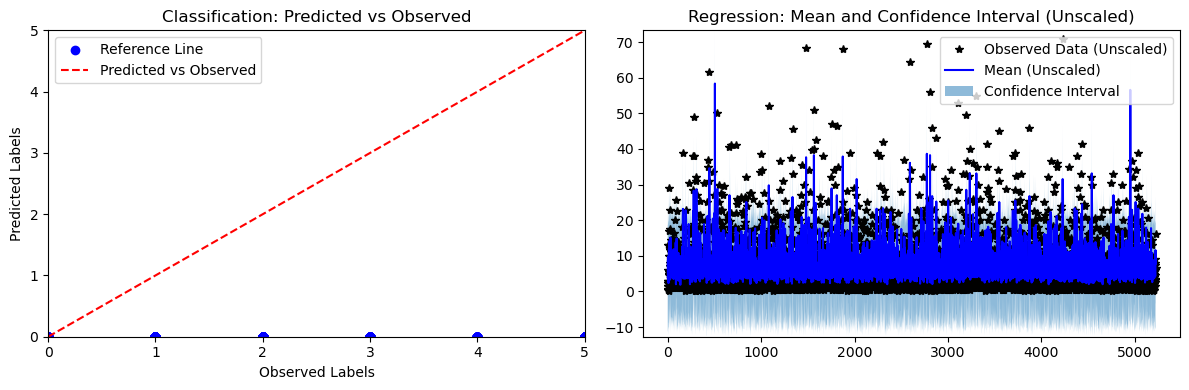

In [12]:
# Set models and likelihoods to evaluation mode
model_1.eval()
model_2.eval()
likelihood_1.eval()
likelihood_2.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(12, 4))

# Make predictions (use the test tensors X_train_1 and X_train_2)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = [likelihood(model(X_train)) for model, likelihood, X_train in zip(models, likelihoods, [X_train_1, X_train_2])]

# Iterate through the models and predictions
for i, (submodel, prediction, ax) in enumerate(zip(models, predictions, axs)):
    if i == 0:  # Classification Model
        predicted_probabilities = torch.softmax(prediction.mean, dim=0)  # Apply softmax across the class dimension
        predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()  # Use argmax on the class dimension
        print(predicted_probabilities)
        print(predicted_labels)
        
        # Ensure y_train_1 is flattened to match the predicted_labels shape
        y_train_1_flat = y_train_1.numpy().flatten()

        # Plot Predicted vs Observed labels
        if y_train_1_flat.shape == predicted_labels.shape:
            ax.scatter(y_train_1_flat, predicted_labels, c='b', marker='o')  # Scatter plot of predicted vs observed
            ax.plot([0, len(label_encoder.classes_) - 1], [0, len(label_encoder.classes_) - 1], 'r--')  # Diagonal line for reference
            ax.set_title('Classification: Predicted vs Observed')
            ax.set_xlabel('Observed Labels')
            ax.set_ylabel('Predicted Labels')
            ax.set_xlim([0, len(label_encoder.classes_) - 1])
            ax.set_ylim([0, len(label_encoder.classes_) - 1])
            ax.legend(['Reference Line', 'Predicted vs Observed'])
        else:
            print("Warning: Shapes of y_train_1 and predicted_labels do not match!")

    else:  # Regression Model
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

        # Reverse the standardization for the mean and confidence intervals
        mean_unscaled = scaler.inverse_transform(mean.numpy().reshape(-1, 1)).flatten()
        lower_unscaled = scaler.inverse_transform(lower.numpy().reshape(-1, 1)).flatten()
        upper_unscaled = scaler.inverse_transform(upper.numpy().reshape(-1, 1)).flatten()
        y_train_unscaled = scaler.inverse_transform(y_train_2.numpy().reshape(-1, 1)).flatten()

        # Plot the unscaled test data and predictions
        ax.plot(range(len(y_train_unscaled)), y_train_unscaled, 'k*')  # Plot the unscaled test targets
        ax.plot(range(len(mean_unscaled)), mean_unscaled, 'b')  # Unscaled predictive mean as blue line
        # Shade in confidence interval
        ax.fill_between(range(len(mean_unscaled)), lower_unscaled, upper_unscaled, alpha=0.5)
        ax.set_ylim([min(lower_unscaled), max(upper_unscaled)])  # Adjust the y-axis limits
        ax.set_title('Regression: Mean and Confidence Interval (Unscaled)')
        ax.legend(['Observed Data (Unscaled)', 'Mean (Unscaled)', 'Confidence Interval'])

plt.tight_layout()
plt.show()

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
[0 0 0 ... 0 0 0]


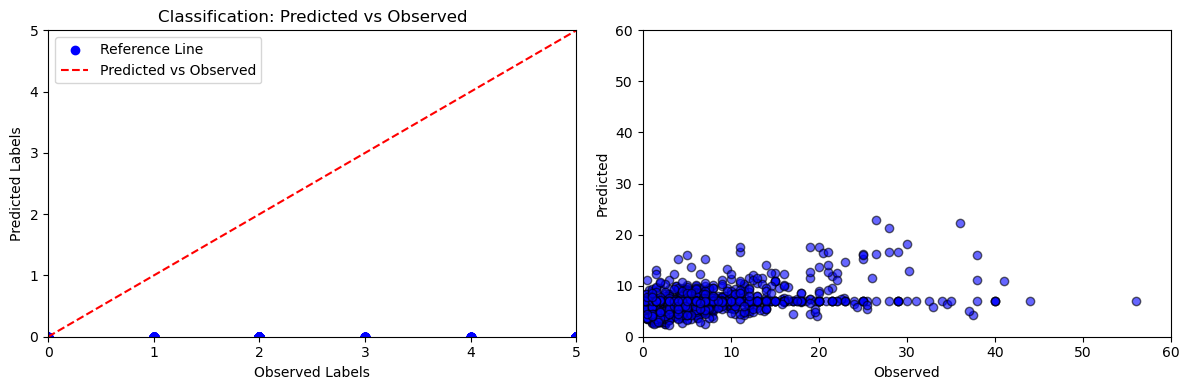

In [19]:
# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(12, 4))

# Make predictions (use the test tensors X_test_1 and X_test_2)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = [likelihood(model(X_test)) for model, likelihood, X_test in zip(models, likelihoods, [X_test_1, X_test_2])]

# Iterate through the models and predictions
for i, (submodel, prediction, ax) in enumerate(zip(models, predictions, axs)):
    if i == 0:  # Classification Model
        predicted_probabilities = torch.softmax(prediction.mean, dim=0)  # Apply softmax across the class dimension
        predicted_labels = predicted_probabilities.argmax(dim=0).detach().numpy()  # Use argmax on the class dimension
        print(predicted_probabilities)
        print(predicted_labels)

        # Ensure y_test_1 is flattened to match the predicted_labels shape
        y_test_1_flat = y_test_1.numpy().flatten()

        # Plot Predicted vs Observed labels
        if y_test_1_flat.shape == predicted_labels.shape:
            ax.scatter(y_test_1_flat, predicted_labels, c='b', marker='o')  # Scatter plot of predicted vs observed
            ax.plot([0, len(label_encoder.classes_) - 1], [0, len(label_encoder.classes_) - 1], 'r--')  # Diagonal line for reference
            ax.set_title('Classification: Predicted vs Observed')
            ax.set_xlabel('Observed Labels')
            ax.set_ylabel('Predicted Labels')
            ax.set_xlim([0, len(label_encoder.classes_) - 1])
            ax.set_ylim([0, len(label_encoder.classes_) - 1])
            ax.legend(['Reference Line', 'Predicted vs Observed'])
        else:
            print("Warning: Shapes of y_test_1 and predicted_labels do not match!")

    else:  # Regression Model
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

        # Reverse the standardization for the mean and confidence intervals
        mean_unscaled = scaler.inverse_transform(mean.numpy().reshape(-1, 1)).flatten()
        lower_unscaled = scaler.inverse_transform(lower.numpy().reshape(-1, 1)).flatten()
        upper_unscaled = scaler.inverse_transform(upper.numpy().reshape(-1, 1)).flatten()
        y_test_unscaled = scaler.inverse_transform(y_test_2.numpy().reshape(-1, 1)).flatten()

        # # Plot the unscaled test data and predictions
        # ax.plot(range(len(y_test_unscaled)), y_test_unscaled, 'k*')  # Plot the unscaled test targets
        # ax.plot(range(len(mean_unscaled)), mean_unscaled, 'b')  # Unscaled predictive mean as blue line
        # # Shade in confidence interval
        # ax.fill_between(range(len(mean_unscaled)), lower_unscaled, upper_unscaled, alpha=0.5)
        # ax.set_ylim([min(lower_unscaled), max(upper_unscaled)])  # Adjust the y-axis limits
        # ax.set_title('Regression: Mean and Confidence Interval (Unscaled)')
        # ax.legend(['Observed Data (Unscaled)', 'Prediction Mean (Unscaled)', 'Confidence Interval'])        
        ax.scatter(y_test_unscaled, mean_unscaled, c='blue', alpha=0.6, edgecolors='k', label='Predicted vs Observed')
        ax.set_xlim(0,60)
        ax.set_ylim(0,60)
        ax.set_xlabel('Observed')
        ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

____________________

Sources:
1. https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/ModelList_GP_Regression.html
2. https://jamesbrind.uk/posts/2d-gaussian-process-regression/